<a href="https://colab.research.google.com/github/indreshverma2004/NLP_Assignment/blob/main/Indresh_NLP_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this first cell in Colab
# Most libs are preinstalled, but we ensure seaborn & nltk data
%pip install -q seaborn

import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)
import joblib   # for saving models

# nltk for stopwords / tokenization
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files

uploaded = files.upload()   # choose your Sentences_AllAgree.txt
# After upload, use filename exactly as uploaded (or take first key)
fname = list(uploaded.keys())[0]
print("Loaded file:", fname)

# Read file lines and parse using '@' delimiter (last occurrence)
with open(fname, 'r', encoding='ISO-8859-1') as f:
    lines = f.readlines()

# Split into sentence and label (rsplit by '@', once)
data = []
for line in lines:
    line = line.strip()
    if not line:
        continue
    parts = line.rsplit('@', 1)
    if len(parts) == 2:
        sentence, label = parts[0].strip(), parts[1].strip()
    else:
        # fallback if no delimiter found
        sentence = parts[0].strip()
        label = ''
    data.append((sentence, label))

df = pd.DataFrame(data, columns=['sentence', 'label'])
print("Dataset loaded. Examples:")
display(df.head())
print("\nDataset size:", len(df))
print(df['label'].value_counts())


Saving Sentences_AllAgree.txt to Sentences_AllAgree.txt
Loaded file: Sentences_AllAgree.txt
Dataset loaded. Examples:


,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive



Dataset size: 2264
label
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


In [ ]:
# Inspect unique labels
print("Unique labels:", df['label'].unique())

# Example mappings: adjust to your dataset's label text
# Suppose labels are 'positive', 'negative', 'neutral' (case-insensitive)
df['label_clean'] = df['label'].str.lower().str.strip()

# Map to canonical categories (edit mapping if labels differ)
mapping = {
    'positive': 'positive',
    'pos': 'positive',
    'p': 'positive',
    'negative': 'negative',
    'neg': 'negative',
    'n': 'negative',
    'neutral': 'neutral',
    'neu': 'neutral',
    '0': 'neutral',
    '1': 'positive',
    '2': 'negative',
    # add any other variants found in your label column
}

# Apply mapping; unknown labels will become NaN -> drop or inspect
df['sentiment'] = df['label_clean'].map(mapping)

# Show rows with unmapped labels (if any)
unmapped = df[df['sentiment'].isna()][['label', 'label_clean']].drop_duplicates()
if not unmapped.empty:
    print("Unmapped labels found (please update `mapping`):")
    display(unmapped)
else:
    print("All labels mapped successfully.")

# Drop rows with missing label mapping (if present)
df = df.dropna(subset=['sentiment']).reset_index(drop=True)
print("\nCounts per sentiment:")
print(df['sentiment'].value_counts())


Unique labels: ['neutral' 'positive' 'negative']
All labels mapped successfully.

Counts per sentiment:
sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


In [ ]:
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+','', text)      # remove URLs
    text = re.sub(r'[^a-z0-9\s]', ' ', text)       # remove punctuations (keep numbers)
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOPWORDS]
    return ' '.join(tokens)

# Apply
df['text'] = df['sentence'].astype(str).apply(preprocess)
print("Example preprocessed:")
display(df[['sentence','text','sentiment']].head())


Example preprocessed:


,sentence,text,sentiment
0,"According to Gran , the company has no plans t...",according gran company plans move production r...,neutral
1,"For the last quarter of 2010 , Componenta 's n...",last quarter 2010 componenta net sales doubled...,positive
2,"In the third quarter of 2010 , net sales incre...",third quarter 2010 net sales increased 5 2 eur...,positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,operating profit rose eur 13 1 mn eur 8 7 mn c...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",operating profit totalled eur 21 1 mn eur 18 6...,positive


In [ ]:
X = df['text'].values
y = df['sentiment'].values

# stratify helps keep class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Train class distribution:\n", pd.Series(y_train).value_counts())
print("Test class distribution:\n", pd.Series(y_test).value_counts())


Train size: 1811 Test size: 453
Train class distribution:
 neutral     1113
positive     456
negative     242
Name: count, dtype: int64
Test class distribution:
 neutral     278
positive    114
negative     61
Name: count, dtype: int64


In [ ]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Classifier
clf = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear', random_state=42)
clf.fit(X_train_tfidf, y_train)

# Save vectorizer + model (optional)
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(clf, 'logreg_sentiment.joblib')


['logreg_sentiment.joblib']

In [ ]:
y_pred = clf.predict(X_test_tfidf)

# Counts: actual vs predicted
actual_counts = pd.Series(y_test).value_counts()
pred_counts = pd.Series(y_pred).value_counts()
print("Actual counts:\n", actual_counts)
print("Predicted counts:\n", pred_counts)

# Overall metrics
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision (macro): {prec_macro:.4f}")
print(f"Recall (macro): {rec_macro:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}\n")

# Per-class report
print("Classification report:\n")
print(classification_report(y_test, y_pred, zero_division=0))


Actual counts:
 neutral     278
positive    114
negative     61
Name: count, dtype: int64
Predicted counts:
 neutral     299
positive    101
negative     53
Name: count, dtype: int64

Accuracy: 0.8477
Precision (macro): 0.8211
Recall (macro): 0.7784
F1-score (macro): 0.7972

Classification report:

              precision    recall  f1-score   support

    negative       0.81      0.70      0.75        61
     neutral       0.88      0.95      0.91       278
    positive       0.77      0.68      0.73       114

    accuracy                           0.85       453
   macro avg       0.82      0.78      0.80       453
weighted avg       0.84      0.85      0.84       453



Confusion Matrix:



,positive,negative,neutral
positive,78,7,29
negative,11,43,7
neutral,12,3,263


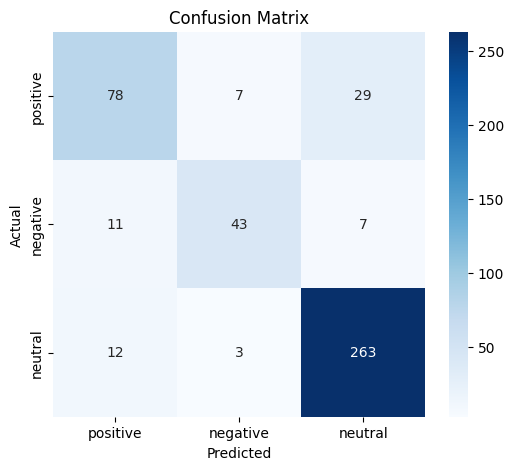

In [ ]:
labels = ['positive','negative','neutral']   # ensure order matches your classes
cm = confusion_matrix(y_test, y_pred, labels=labels)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion Matrix:\n")
display(cm_df)

# Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("Full dataset counts:\n", df['sentiment'].value_counts())
print("\nTrain counts:\n", pd.Series(y_train).value_counts())
print("\nTest counts:\n", pd.Series(y_test).value_counts())

# Predicted counts across test
print("\nPredicted on test:\n", pd.Series(y_pred).value_counts())


Full dataset counts:
 sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Train counts:
 neutral     1113
positive     456
negative     242
Name: count, dtype: int64

Test counts:
 neutral     278
positive    114
negative     61
Name: count, dtype: int64

Predicted on test:
 neutral     299
positive    101
negative     53
Name: count, dtype: int64
